In [1]:
import matplotlib.pyplot as plt
import ngff_zarr as nz
from processing_tools import ArrayProcessor
import numpy as np
from plotting_utils import create_well_plate_heatmap

In [2]:
# define file paths and parameters

hcs_omezarr_path: str = r"F:\Testdata_Zeiss\OME_ZARR_Testfiles\testwell96_HCSplate.ome.zarr"
#hcs_omezarr_path: str = r"F:\Github\omezarr_playground\data\WP96_4Pos_B4-10_DAPI_HCSplate.ome.zarr"
channel2analyze = 0  # Index of the channel to analyze
measure_properties = ("label", "area", "centroid", "bbox")

In [3]:
# this is the main function to process HCS OME-ZARR files
# feel free to adapt the actual processing steps as needed

def process_hcs_omezarr(
    hcs_omezarr_path: str, channel2analyze: int = 0, measure_properties=("label", "area", "centroid", "bbox")
):
    """
    Process an HCS OME-ZARR file to analyze wells and generate heatmaps.

    Parameters:
        hcs_omezarr_path (str): Path to the HCS OME-ZARR file.
        channel2analyze (int): Index of the channel to analyze.
    """

    try:
        print("Validating created HCS-ZARR file against schema...")
        hcs_plate = nz.from_hcs_zarr(hcs_omezarr_path, validate=True)
        print("Validation successful.")
    except Exception as e:
        print(f"Validation failed: {e}")
        raise e

    # run some processing
    results_obj = {}
    results_mean = {}

    # Debug: Print plate metadata information
    print(f"Number of wells in metadata: {len(hcs_plate.metadata.wells)}")
    print(f"Wells in metadata: {[w.path for w in hcs_plate.metadata.wells]}")

    # Iterate through all wells that actually have data
    # Use the well path directly since it's always correct (e.g., "B/4")
    for well_meta in hcs_plate.metadata.wells:

        # Extract row and column from the path (format: "B/4")
        row, col = well_meta.path.split("/")
        print(f"\nProcessing well: {well_meta.path} (Row: {row}, Column: {col})")

        # Get the well object for the current row/column position
        well = hcs_plate.get_well(row, col)

        # Only process if the well exists and has data
        if not well:
            print(f"  Warning: Well {well_meta.path} not found in plate, skipping")
            continue

        if not well.images or len(well.images) == 0:
            print(f"  Warning: Well {well_meta.path} has no images, skipping")
            continue

        # Store intensities for all fields (positions) within the well
        field_intensities = []
        field_num_objects = []

        print(f"  Found {len(well.images)} field(s) in well {well_meta.path}")

        # Process each field (microscope position) in the current well
        for field_idx in range(len(well.images)):

            image = well.get_image(field_idx)

            if image:

                # Load the image data into memory (compute() for dask arrays)
                data = image.images[0].data.compute()
                print(
                    f"Processing well: {well_meta.path} - Field {field_idx} data shape: {data.shape}, dtype: {data.dtype}"
                )

                # count objects
                ap = ArrayProcessor(np.squeeze(data[:, channel2analyze, ...]))  # 2D data as input
                pro2d = ap.apply_otsu_threshold()
                ap = ArrayProcessor(pro2d)
                pro2d, num_objects, props = ap.label_objects(
                    min_size=100,
                    label_rgb=False,
                    orig_image=None,
                    bg_label=0,
                    measure_params=True,
                    measure_properties=measure_properties,
                )

                # store number of objects for this field
                field_num_objects.append(int(num_objects))

                # Calculate mean intensity for this field
                mean_intensity = np.mean(data)
                field_intensities.append(mean_intensity)

        # Store the average intensity across all fields for this well
        results_mean[f"{row}/{col}"] = np.mean(field_intensities)

        # Store the total number of objects across all fields for this well
        results_obj[f"{row}/{col}"] = np.sum(field_num_objects)

    # Report the number of wells processed
    print(f"Total Size of results: {len(results_mean)}")

    return results_obj


In [4]:
# Run the processing function and return results

results_obj = process_hcs_omezarr(
    hcs_omezarr_path=hcs_omezarr_path, channel2analyze=channel2analyze, measure_properties=measure_properties
)

Validating created HCS-ZARR file against schema...
Validation successful.
Number of wells in metadata: 96
Wells in metadata: ['A/1', 'A/2', 'A/3', 'A/4', 'A/5', 'A/6', 'A/7', 'A/8', 'A/9', 'A/10', 'A/11', 'A/12', 'B/1', 'B/2', 'B/3', 'B/4', 'B/5', 'B/6', 'B/7', 'B/8', 'B/9', 'B/10', 'B/11', 'B/12', 'C/1', 'C/2', 'C/3', 'C/4', 'C/5', 'C/6', 'C/7', 'C/8', 'C/9', 'C/10', 'C/11', 'C/12', 'D/1', 'D/2', 'D/3', 'D/4', 'D/5', 'D/6', 'D/7', 'D/8', 'D/9', 'D/10', 'D/11', 'D/12', 'E/1', 'E/2', 'E/3', 'E/4', 'E/5', 'E/6', 'E/7', 'E/8', 'E/9', 'E/10', 'E/11', 'E/12', 'F/1', 'F/2', 'F/3', 'F/4', 'F/5', 'F/6', 'F/7', 'F/8', 'F/9', 'F/10', 'F/11', 'F/12', 'G/1', 'G/2', 'G/3', 'G/4', 'G/5', 'G/6', 'G/7', 'G/8', 'G/9', 'G/10', 'G/11', 'G/12', 'H/1', 'H/2', 'H/3', 'H/4', 'H/5', 'H/6', 'H/7', 'H/8', 'H/9', 'H/10', 'H/11', 'H/12']

Processing well: A/1 (Row: A, Column: 1)
  Found 1 field(s) in well A/1
Processing well: A/1 - Field 0 data shape: (1, 2, 1, 1416, 1960), dtype: uint16

Processing well: A/2 (Ro

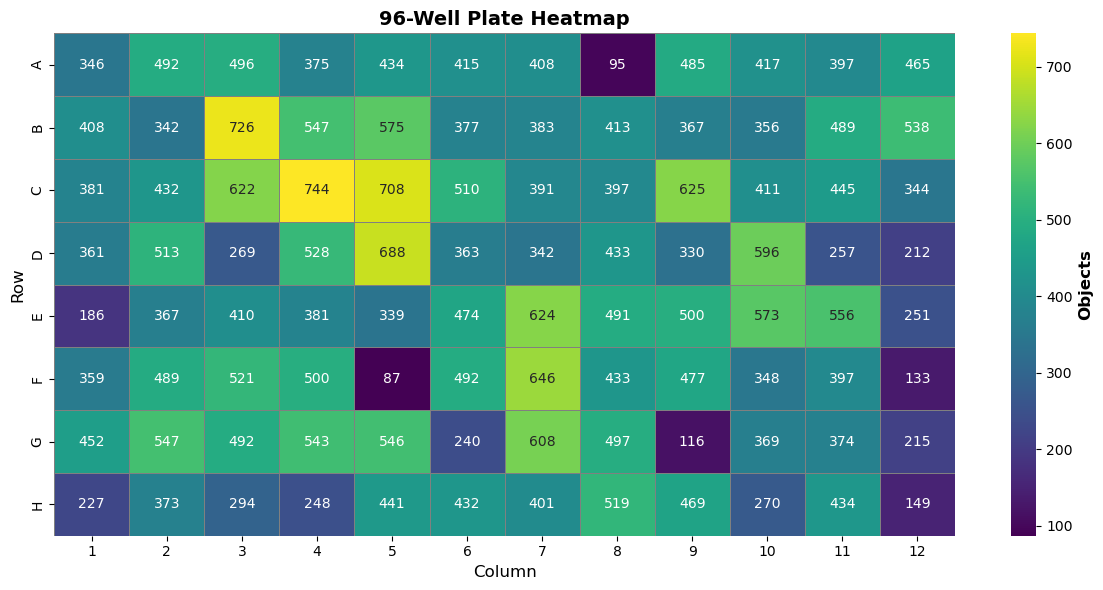

In [5]:
# Create and display heatmap visualization using the dedicated function
fig = create_well_plate_heatmap(
    results=results_obj,
    num_rows=8,  # Standard 96-well plate
    num_cols=12,  # Standard 96-well plate
    title="96-Well Plate Heatmap",
    parameter="Objects",
    cmap="viridis",
    figsize=(12, 6),
    fmt=".0f",
)

plt.show()